# More on Specification and Data Issues

## 1. Functional Form Misspecification

We have seen many ways to flexibly specify the relation between the dependent variable and the regressors. An obvious question to ask is whether or not a given specification is the "correct" one.

The **Regression Equation Specification Error Test** (RESET) is a convenient tool to test the null hypothesis that the functional form is *adequate*.

> Since this is still in the context of an hypothesis test, the idea is similar - in the first step, we make an assumption. Second, if the assumption is true, we deduce a statistic and assert it must satisfy a certain distribution under the assumption. Third, if the p-value (probability of getting a value extremer than the current one) is small, we reject the null hypothesis. 

? If you were asked to develop such a hypothesis test, what would you do?

### Ramsey RESET test,

- Step 1, regress y on x and obtain $\hat{y}$.
- Step 2, regress y on x, $\hat{y}^2$, and $\hat{y}^3$: $y=\gamma_0 + \gamma_1 x + \gamma_2 \hat{y}^2 + \gamma_3 \hat{y}^3 + v$
- If $y = \beta_0 + \beta_1 x$ + u is the correct specification, we have $H_0: \gamma_2 = \gamma_3 = 0$
- We can carry out an f_test on the second regression.

Exercise: use the hprice1 dataset from wooldridge, regress house price (*price*) on size of lot in square feet (*lotsize*), size of house in square feet (*sqrft*), and number of bed rooms (*bdrms*). Carry out a RESET test to see if higher-ordered independent variables are needed.

In [14]:
# original OLS
import wooldridge as woo
import statsmodels.formula.api as smf

df = woo.data("hprice1")
formula = "price ~ lotsize + sqrft + bdrms"
reg1 = smf.ols(formula, data=df)
res1 = reg1.fit()

In [15]:
df["y_h"] = res1.fittedvalues

In [16]:
# regression for RESET test
reg2 = smf.ols(formula + "+ I(y_h**2) + I(y_h**3)", data=df) 
# I() means identical transformation, it tells smf to compute the operation inside the () first. 
res2 = reg2.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.706
Model:                            OLS   Adj. R-squared:                  0.688
Method:                 Least Squares   F-statistic:                     39.35
Date:                Wed, 17 Nov 2021   Prob (F-statistic):           2.02e-20
Time:                        21:27:55   Log-Likelihood:                -478.13
No. Observations:                  88   AIC:                             968.3
Df Residuals:                      82   BIC:                             983.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     166.0973    317.433      0.523      

In [17]:
hypo = reg.exog_names[-2:]
res.f_test(hypo)

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[4.66820553]]), p=0.012021711442904287, df_denom=82, df_num=2>

Conclusion: We reject the null hypothesis that this equation is correctly specified at a significance level of $\alpha = 5\%$

### smo.reset_ramsey() 

The statsmodels.stats.outliers_influence module has a function called *reset_ramsey()* who implements this test.

> variance_inflation_factor() is in the same module

In [18]:
import statsmodels.stats.outliers_influence as smo

smo.reset_ramsey(res1, degree = 3)

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[4.66820553]]), p=0.012021711442877286, df_denom=82, df_num=2>

## 2. Measurement Error

If a variable is not measured accurately, the consequences depend on whether the measurement error affects the dependent or an explanatory variable. 

If the dependent variable is mismeasured, the consequences can be mild. It can be treated as another part of u.

If the independent variable is mismeasured, the consequences are usually more dramatic. Even when we assume the measurement error is independent.

Consider a simple linear regression. Let $x^*$ denotes the true independent variable, and $x = x^* + e$ is the observed value. $e$ is independent of both $x^*$ and $u$.

**TRUE**: $y = \beta_0 + \beta_1 x^* + u$
**OLS Regression**: Regress y on $(x^*+u)$

We can show that

$$\hat{\beta_1} = \beta_1*\frac{Var(x^*)}{Var(x^*)+Var(e)} \le \beta_1$$

So measurement error leads to an *attenuation* bias, if we have a random error. If the error term is not random, we do not have a uniform conclusion.

## 3. Missing Data

In many data sets, we fail to observe all variables for each observational unit. An import case is survey data where the respondents refuse or fail to answer some questions.

We can use `df.info()` to list the number of non-missing observations for each column.

Exercise: import lawsch85 from woo, and display the info().

In [19]:
df = woo.data("lawsch85")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 21 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   rank     156 non-null    int64  
 1   salary   148 non-null    float64
 2   cost     150 non-null    float64
 3   LSAT     150 non-null    float64
 4   GPA      149 non-null    float64
 5   libvol   155 non-null    float64
 6   faculty  152 non-null    float64
 7   age      111 non-null    float64
 8   clsize   153 non-null    float64
 9   north    156 non-null    int64  
 10  south    156 non-null    int64  
 11  east     156 non-null    int64  
 12  west     156 non-null    int64  
 13  lsalary  148 non-null    float64
 14  studfac  150 non-null    float64
 15  top10    156 non-null    int64  
 16  r11_25   156 non-null    int64  
 17  r26_40   156 non-null    int64  
 18  r41_60   156 non-null    int64  
 19  llibvol  155 non-null    float64
 20  lcost    150 non-null    float64
dtypes: float64(12), 

### Change values to np.nan
Depending on the data source, real-world data sets can have different rules for indicating missing information. Sometimes, impossible numeric values are used. For example, a survey including the number of years of education as a variable educ might have a value like "9999" to indicate missing information. For any software package, it is highly recommended to change these to proper missing value codes early in the data-handling process. Otherwise, we take the risk that some statistical method interprets those values as "this person went to school for 9999 years" producing highly nonsensical results.

For the education example, if the variable *educ* is in the data frame *mydata* this can be done with

```python
mydata.loc[mydata["educ"] == 9999, "educ"] = np.nan
```



### Label missing values

We can also create Boolean variables indicating missing values using the **pandas** method isna. For example `mydata["educ"].isna()` will generate a Boolean Series with *True* values whenever the educ observation is np.nan.

This method can also be used on data frames. It returns a dataframe of Boolean values.

In [20]:
df.isna()

,rank,salary,cost,LSAT,GPA,libvol,faculty,age,clsize,north,...,east,west,lsalary,studfac,top10,r11_25,r26_40,r41_60,llibvol,lcost
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
152,False,False,False,False,False,True,False,True,False,False,...,False,False,False,False,False,False,False,False,True,False
153,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
154,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


It can be useful to call `any()` and `all()` function on this Boolean dataframe to detect if the entire column (default, or row - set axis=1) contains any or all missing values.

In [21]:
df.isna().any()

rank       False
salary      True
cost        True
LSAT        True
GPA         True
libvol      True
faculty     True
age         True
clsize      True
north      False
south      False
east       False
west       False
lsalary     True
studfac     True
top10      False
r11_25     False
r26_40     False
r41_60     False
llibvol     True
lcost       True
dtype: bool

In [22]:
df.isna().all()

rank       False
salary     False
cost       False
LSAT       False
GPA        False
libvol     False
faculty    False
age        False
clsize     False
north      False
south      False
east       False
west       False
lsalary    False
studfac    False
top10      False
r11_25     False
r26_40     False
r41_60     False
llibvol    False
lcost      False
dtype: bool

In [23]:
df.isna().any(axis=1)

0      False
1      False
2      False
3      False
4      False
       ...  
151    False
152     True
153    False
154    False
155     True
Length: 156, dtype: bool

In [24]:
df.isna().all(axis=1)

0      False
1      False
2      False
3      False
4      False
       ...  
151    False
152    False
153    False
154    False
155    False
Length: 156, dtype: bool

### Exercise: 
use the lawsch85 data set from woo. 
1. Label missing values in column "LSAT" - law schools who do not report the median LSAT score.
2. Create a crosstabulation to display the number of missing values for *top10* versus non-top 10 law schools
3. Label missings for all variables in data frame
4. Compute the amount of complete cases

In [28]:
df.isna()["LSAT"]

0      False
1      False
2      False
3      False
4      False
       ...  
151    False
152    False
153    False
154    False
155     True
Name: LSAT, Length: 156, dtype: bool

In [30]:
import pandas as pd
pd.crosstab(df.isna()["LSAT"], df["top10"])

top10,0,1
LSAT,,
False,140,10
True,6,0


In [38]:
df.isna().all(axis=1)

0      False
1      False
2      False
3      False
4      False
       ...  
151    False
152    False
153    False
154    False
155    False
Length: 156, dtype: bool

In [39]:
len(df) - df.isna().all(axis=1).sum(axis=0)

156

### Drop missing observations

We can use `df.dropna()` function to drop observations with any or all missing values. ([dropna](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html)). For example, if we want to drop observations with any missing values, we can use the default setting `df.dropna()`. If we want to drop observations with all missing values, we can use the "how=" parameter - `df.dropna(how="all")` .

> df.dropna creates a copy, so do not forget to reassign it to df.

Exercise: Drop observations with any missing values in the lawsch85 data set. Show the number of observations left.

### Fill missing values - often used in Data Science

In econometrics, we prefer not to fill na values use only the complete observations. But the nature of data science means they need more observations in order to have convergence, which leads to the need of filling missing values.

Here, we are going to introduce three common techniques to fill na values.

1. **Forward fill**

Forward fill will propagate the last valid observation forward. This commonly used in time series data, where an event occurs in one year, but its effect persists for all following periods.

```python
df["col1"].fillna(method = "ffill")
```

2. **Back fill**

Backfill will backward fill the NaN values with the next valid value.
```python
df["col2"].fillna(method="bfill")
```
3. **Interpolate**

```python
df["col3"].interpolate()
```
This function will fill NA values using interpolation methods (by default it implements linear interpolation). It works well on sorted values. For example

In [43]:
import numpy as np
s = pd.Series([0, 1, np.nan, 3])
print(s)
s.interpolate()

0    0.0
1    1.0
2    NaN
3    3.0
dtype: float64


0    0.0
1    1.0
2    2.0
3    3.0
dtype: float64

## 4 Outliers

OLS is susceptible to outlying observations because it minimizes the sum of squared residuals: large residuals (positive or negative) receive a lot of weight in the least squares minimization problem. If the estimates change by a practically large amount when we slightly modify our sample, we should be concerned.

Suppose that R&D expenditures as a percentage of sales (rdintens) are related to sales (in millions) and profits as a percentage of sales ( profmarg):
1. Compute the The OLS result using data on 32 chemical companies in RDCHEM dataset
2. Comment on the significance of the independent variables
3. Scatter plot R&D intensity (*rdintens*) against firm sales (*sales*)
4. Drop the outlier and rerun the regression

In [44]:
df = woo.data("rdchem")
reg = smf.ols("rdintens ~ sales + profmarg", data=df)
res = reg.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               rdintens   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     1.195
Date:                Wed, 17 Nov 2021   Prob (F-statistic):              0.317
Time:                        23:55:11   Log-Likelihood:                -63.725
No. Observations:                  32   AIC:                             133.4
Df Residuals:                      29   BIC:                             137.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.6253      0.586      4.484      0.0

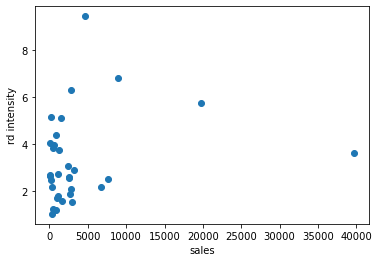

In [47]:
import matplotlib.pyplot as plt
plt.scatter(y = df["rdintens"], x = df["sales"])
plt.ylabel("rd intensity")
plt.xlabel("sales")
plt.show()

In [51]:
reg = smf.ols("rdintens~sales+profmarg", data=df[df["sales"]<35000])
print(reg.fit().summary())

                            OLS Regression Results                            
Dep. Variable:               rdintens   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     2.925
Date:                Wed, 17 Nov 2021   Prob (F-statistic):             0.0702
Time:                        23:58:50   Log-Likelihood:                -60.496
No. Observations:                  31   AIC:                             127.0
Df Residuals:                      28   BIC:                             131.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.2969      0.592      3.881      0.0

### Studentized residual

Studentized residuals are obtained from the original OLS residuals by dividing them by an estimate of their standard deviation. This can be used as a measure of how far away an observation is from the mean in a standardized term.

In statsmodels, we can calculate this standardized residual by calling the `get_influence().resid_studentized_external` attribute on the result object from the original regression.

In [55]:
studres = res.get_influence().resid_studentized_external

We can then display the min, max, and a histogram of the studentized residual.

In [56]:
np.min(studres), np.max(studres)

(-1.8180393952811738, 4.555033421514247)

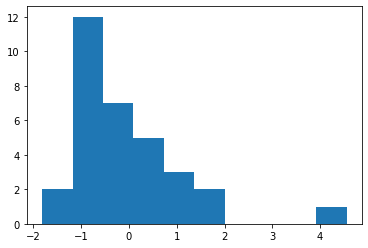

In [60]:
plt.hist(studres)
plt.show()

The highest value appears to be an extremely outlying value.

> To get the index of this extreme value, use `np.argmax(studres)`

In [61]:
np.argmax(studres)

0

Exercise:

Data on infant mortality, per capita income, and measures of health care can be obtained at the state level from the Statistical Abstract of the United States. We will provide a fairly simple analysis here just to illustrate the effect of outliers. The data are for the year 1990, and we have all 50 states in the United States, plus the District of Columbia (D.C.). The variable **infmort** is number of deaths within the first year per 1,000 live births, **pcinc** is per capita income, **physic** is physicians per 100,000 members of the civilian population, and **popul** is the population (in thousands). The data are contained in **INFMRT**. We use all independent variables in logarithmic form

In [80]:
df = woo.data("infmrt")
df = df.loc[df["year"]==1990,:]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51 entries, 1 to 101
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   year     51 non-null     int64  
 1   infmort  51 non-null     float64
 2   afdcprt  51 non-null     int64  
 3   popul    51 non-null     int64  
 4   pcinc    51 non-null     int64  
 5   physic   51 non-null     int64  
 6   afdcper  51 non-null     float64
 7   d90      51 non-null     int64  
 8   lpcinc   51 non-null     float64
 9   lphysic  51 non-null     float64
 10  DC       51 non-null     int64  
 11  lpopul   51 non-null     float64
dtypes: float64(5), int64(7)
memory usage: 5.2 KB


In [81]:
reg = smf.ols("infmort ~ lpcinc + lphysic + lpopul", data=df)
res = reg.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                infmort   R-squared:                       0.139
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     2.531
Date:                Thu, 18 Nov 2021   Prob (F-statistic):             0.0684
Time:                        00:26:01   Log-Likelihood:                -107.09
No. Observations:                  51   AIC:                             222.2
Df Residuals:                      47   BIC:                             229.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     33.8593     20.428      1.658      0.1

Higher per capita income is estimated to lower infant mortality, an expected result. But more physicians per capita is associated with higher infant mortality rates, something that is counterintuitive. Infant mortality rates do not appear to be related to population size.

Now compute the studentized residuals and plot a histogram.

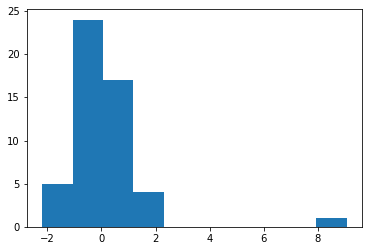

In [82]:
studres = res.get_influence().resid_studentized_external
plt.hist(studres)
plt.show()

In [83]:
np.argmax(studres)

23

In [85]:
df.iloc[np.argmax(studres)]

year        1990.000000
infmort       20.700001
afdcprt       54.000000
popul        607.000000
pcinc      23885.000000
physic       615.000000
afdcper        8.896211
d90            1.000000
lpcinc        10.081006
lphysic        6.421622
DC             1.000000
lpopul         6.408529
Name: 47, dtype: float64

The District of Columbia is unusual in that it has pockets of extreme poverty and great wealth in a small area. In fact, the infant mortality rate for D.C. in 1990 was 20.7, compared with 12.4 for the highest state. It also has 615 physicians per 100,000 of the civilian population, compared with 337 for the highest state. The high number of physi- cians coupled with the high infant mortality rate in D.C. could certainly influence the results. If we drop D.C. from the regression, we obtain

In [86]:
smf.ols("infmort ~ lpcinc + lphysic + lpopul", data=df.drop(index=47)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                infmort   R-squared:                       0.273
Model:                            OLS   Adj. R-squared:                  0.226
Method:                 Least Squares   F-statistic:                     5.763
Date:                Thu, 18 Nov 2021   Prob (F-statistic):            0.00197
Time:                        00:26:15   Log-Likelihood:                -79.876
No. Observations:                  50   AIC:                             167.8
Df Residuals:                      46   BIC:                             175.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     23.9548     12.419      1.929      0.060      -1.044      48.954
lpcinc        -0.5669      1.641     -0.345      0.731      -3.871       2.737
lphysic       -2.7418      1.191     -2.303      0.026      -5.139      -0.345
lpopul         0.6292      0.191      3.293      0.002       0.245       1.014
==============================================================================
Omnibus:                        0.970   Durbin-Watson:                   1.388
Prob(Omnibus):                  0.616   Jarque-Bera (JB):                0.955
Skew:                           0.169   Prob(JB):                        0.620
Kurtosis:                       2.413   Cond. No.                         977.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""